In [1]:
pip install gymnasium 

Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym

In [16]:
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')


In [17]:
# Neural Net
class NN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
       

    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.dropout(x, p=0.5)
        x = self.layer3(x)
        return x

In [18]:
# Actor Critic class
class AC(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        action_prob_pred = self.actor(state)
        state_value_pred = self.critic(state)
        
        # returns the action and value
        return action_prob_pred, state_value_pred

In [19]:
# compute the Expected G-value returns
def compute_returns(rewards, discount_factor):
    
    returns = []
    G = 0
    
    for g in reversed(rewards):
        G = g + G * discount_factor
        returns.insert(0, G)
        
    returns = torch.tensor(returns)
    
        
    return returns

In [24]:
# calculate the policy loss and value loss
def optimize(returns, log_prob_actions, values, optimizer):
    
    
    policy_loss = - (returns * log_prob_actions).sum()
    value_loss = F.smooth_l1_loss(returns, values).sum()
    
    optimizer.zero_grad()
    
    
    policy_loss.backward()
    value_loss.backward()
    
    optimizer.step()
    
    

In [25]:
# method to test the trained neural network
def test(env, policy):
    
    policy.eval()
    
    done = False
    episode_reward = 0

    state,_ = env.reset()

    for i in range(1000):
        
        state = torch.FloatTensor(state).unsqueeze(0)
        
        with torch.no_grad():
        
            action_prob_pred, _ = policy(state)
        
            action_prob = F.softmax(action_prob_pred, dim = -1)
                            
        action = torch.argmax(action_prob, dim = -1)
            
        state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        episode_reward += reward
        
        if done:
            break
    return episode_reward

In [31]:
#input output shapes for NN
n_observations = train_env.observation_space.shape[0]
n_actions = train_env.action_space.n

#declare actor and critic NN
actor = NN(n_observations, n_actions)
critic = NN(n_observations, 1)
# create AC as policy net
policy_net = AC(actor, critic)
#load weights
policy_net.load_state_dict(policy_net.state_dict())

#Adam optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

#constants
gamma = 0.99  # Discount factor
num_episodes = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

episodes = []
train_rewards = []
test_rewards = []
for episode in range(1, num_episodes+1):
    #set neural nets for training mode
    policy_net.train()
    
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state, _ = test_env.reset()

    for i in range(1000):

        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        action_prob_pred, state_value_pred = policy_net(state)
        
        action_prob = F.softmax(action_prob_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)

        action = dist.sample()

        log_prob_action = dist.log_prob(action)
        
        state, reward, terminated, truncated, _ = test_env.step(action.item())
        done = terminated or truncated
        
        log_prob_actions.append(log_prob_action)
        rewards.append(reward)
        values.append(state_value_pred)

        
        episode_reward += reward
        if done:
            break

    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = compute_returns(rewards, gamma)

    optimize(returns, log_prob_actions, values, optimizer)

    train_reward = episode_reward
    
    test_reward = test(test_env, policy_net)
    
    episodes.append(episode)
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    print('episode: ', episode)
    print('train reward: ', train_reward)
    print('test reward: ', test_reward)
    print()
    
        
        
   


episode:  1
train reward:  33.0
test reward:  10.0

episode:  2
train reward:  21.0
test reward:  12.0

episode:  3
train reward:  50.0
test reward:  25.0

episode:  4
train reward:  10.0
test reward:  66.0

episode:  5
train reward:  22.0
test reward:  56.0

episode:  6
train reward:  28.0
test reward:  44.0

episode:  7
train reward:  33.0
test reward:  78.0

episode:  8
train reward:  24.0
test reward:  35.0

episode:  9
train reward:  15.0
test reward:  51.0

episode:  10
train reward:  41.0
test reward:  26.0

episode:  11
train reward:  18.0
test reward:  24.0

episode:  12
train reward:  14.0
test reward:  23.0

episode:  13
train reward:  11.0
test reward:  23.0

episode:  14
train reward:  34.0
test reward:  22.0

episode:  15
train reward:  34.0
test reward:  14.0

episode:  16
train reward:  22.0
test reward:  17.0

episode:  17
train reward:  14.0
test reward:  31.0

episode:  18
train reward:  40.0
test reward:  17.0

episode:  19
train reward:  28.0
test reward:  18.0

ep

episode:  154
train reward:  124.0
test reward:  139.0

episode:  155
train reward:  49.0
test reward:  111.0

episode:  156
train reward:  123.0
test reward:  120.0

episode:  157
train reward:  40.0
test reward:  137.0

episode:  158
train reward:  72.0
test reward:  162.0

episode:  159
train reward:  95.0
test reward:  150.0

episode:  160
train reward:  113.0
test reward:  126.0

episode:  161
train reward:  109.0
test reward:  132.0

episode:  162
train reward:  48.0
test reward:  132.0

episode:  163
train reward:  213.0
test reward:  137.0

episode:  164
train reward:  177.0
test reward:  202.0

episode:  165
train reward:  160.0
test reward:  164.0

episode:  166
train reward:  112.0
test reward:  317.0

episode:  167
train reward:  75.0
test reward:  223.0

episode:  168
train reward:  267.0
test reward:  313.0

episode:  169
train reward:  362.0
test reward:  387.0

episode:  170
train reward:  262.0
test reward:  282.0

episode:  171
train reward:  107.0
test reward:  500.0

episode:  302
train reward:  211.0
test reward:  218.0

episode:  303
train reward:  168.0
test reward:  244.0

episode:  304
train reward:  176.0
test reward:  219.0

episode:  305
train reward:  205.0
test reward:  230.0

episode:  306
train reward:  135.0
test reward:  258.0

episode:  307
train reward:  118.0
test reward:  306.0

episode:  308
train reward:  121.0
test reward:  313.0

episode:  309
train reward:  153.0
test reward:  353.0

episode:  310
train reward:  163.0
test reward:  428.0

episode:  311
train reward:  250.0
test reward:  500.0

episode:  312
train reward:  378.0
test reward:  500.0

episode:  313
train reward:  243.0
test reward:  500.0

episode:  314
train reward:  263.0
test reward:  500.0

episode:  315
train reward:  454.0
test reward:  500.0

episode:  316
train reward:  209.0
test reward:  500.0

episode:  317
train reward:  246.0
test reward:  500.0

episode:  318
train reward:  58.0
test reward:  500.0

episode:  319
train reward:  276.0
test reward:  

episode:  450
train reward:  214.0
test reward:  196.0

episode:  451
train reward:  226.0
test reward:  194.0

episode:  452
train reward:  244.0
test reward:  206.0

episode:  453
train reward:  193.0
test reward:  249.0

episode:  454
train reward:  236.0
test reward:  239.0

episode:  455
train reward:  226.0
test reward:  243.0

episode:  456
train reward:  171.0
test reward:  236.0

episode:  457
train reward:  230.0
test reward:  247.0

episode:  458
train reward:  263.0
test reward:  235.0

episode:  459
train reward:  221.0
test reward:  273.0

episode:  460
train reward:  232.0
test reward:  252.0

episode:  461
train reward:  283.0
test reward:  263.0

episode:  462
train reward:  321.0
test reward:  265.0

episode:  463
train reward:  258.0
test reward:  302.0

episode:  464
train reward:  233.0
test reward:  267.0

episode:  465
train reward:  256.0
test reward:  273.0

episode:  466
train reward:  249.0
test reward:  335.0

episode:  467
train reward:  342.0
test reward: 

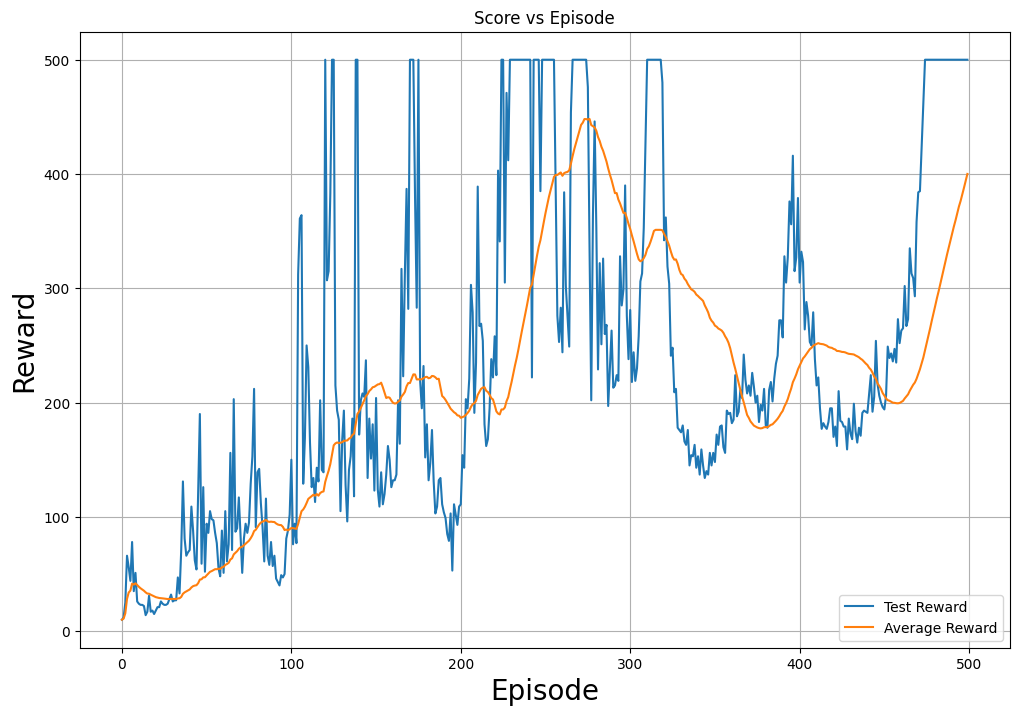

In [35]:
average_reward = []
for idx in range(len(train_rewards)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = test_rewards[:idx+1]
    else:
        avg_list = test_rewards[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.figure(figsize=(12,8))

plt.plot(test_rewards, label='Test Reward')
plt.plot(average_reward, label='Average Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.legend(loc='lower right')
plt.title('Score vs Episode')
plt.grid()